In [1]:
import Pkg
Pkg.activate(".")

  Activating new project at `C:\Users\thake`


In [2]:
Pkg.add(["CairoMakie","LinearAlgebra","Distributions","Convex","SCS"])

    Updating registry at `C:\Users\thake\.julia\registries\General.toml`
   Resolving package versions...
   Installed x265_jll ────────────── v3.6.0+0
   Installed AdaptivePredicates ──── v1.2.0
   Installed EarCut_jll ──────────── v2.2.4+0
   Installed SCS ─────────────────── v2.0.1
   Installed StaticArrays ────────── v1.9.8
   Installed MutableArithmetics ──── v1.5.2
   Installed TiffImages ──────────── v0.10.2
   Installed PlotUtils ───────────── v1.4.2
   Installed OpenBLAS32_jll ──────── v0.3.24+0
   Installed AMD ─────────────────── v0.5.3
   Installed FileIO ──────────────── v1.16.4
   Installed Libgpg_error_jll ────── v1.50.0+0
   Installed SignedDistanceFields ── v0.4.0
   Installed FilePaths ───────────── v0.8.3
   Installed SIMD ────────────────── v3.6.0
   Installed Convex ──────────────── v0.16.3
   Installed ColorSchemes ────────── v3.27.0
   Installed TriplotBase ─────────── v0.1.0
   Installed RoundingEmulator ────── v0.2.1
   Installed Bzip2_jll ───────────── v1.0.8+

In [3]:
using CairoMakie, LinearAlgebra, Statistics, Distributions, Convex, SCS

Precompiling CairoMakie
  ✓ Libmount_jll
  ✓ Xorg_libXdmcp_jll
  ✓ Xorg_libXau_jll
  ✓ EarCut_jll
  ✓ LLVMOpenMP_jll
  ✓ x265_jll
  ✓ Xorg_xtrans_jll
  ✓ x264_jll
  ✓ isoband_jll
  ✓ Libiconv_jll
  ✓ FFTW_jll
  ✓ Xorg_libpthread_stubs_jll
  ✓ FreeType2_jll
  ✓ Isoband
  ✓ XML2_jll
  ✓ FreeType
  ✓ Fontconfig_jll
  ✓ SpecialFunctions → SpecialFunctionsChainRulesCoreExt
  ✓ Gettext_jll
  ✓ XSLT_jll
  ✓ StatsFuns → StatsFunsInverseFunctionsExt
  ✓ IntervalArithmetic → IntervalArithmeticForwardDiffExt
  ✓ ForwardDiff → ForwardDiffStaticArraysExt
  ✓ Glib_jll
  ✓ Xorg_libxcb_jll
  ✓ IntervalArithmetic → IntervalArithmeticIntervalSetsExt
  ✓ Xorg_libX11_jll
  ✓ Xorg_libXrender_jll
  ✓ StatsFuns → StatsFunsChainRulesCoreExt
  ✓ Xorg_libXext_jll
  ✓ GeometryBasics
  ✓ Cairo_jll
  ✓ Distributions → DistributionsTestExt
  ✓ FFTW
  ✓ ExactPredicates
  ✓ Packing
  ✓ ShaderAbstractions
  ✓ HarfBuzz_jll
  ✓ Distributions → DistributionsChainRulesCoreExt
  ✓ libass_jll
  ✓ FreeTypeAbstraction
  ✓ Mak

In [4]:
x = LinRange(0,4,100)
noise_factor = 0.1

#noise function
function generate_noisy_data(x, true_coeffs, noise_std)
    y_true = sum(true_coeffs[i] * x .^ (i - 1) for i in 1:length(true_coeffs))
    noise = noise_factor * randn(length(x))
    return y_true + noise, y_true  
end


generate_noisy_data (generic function with 1 method)

In [5]:
A2 = zeros(length(x), 20)
for i in 1:length(x)
    for j in 1:20
        A2[i, j] = x[i]^(j - 1)
    end
end

In [6]:
function fitlq(A, y)
    Ainv = pinv(A)
    return Ainv * y
end

fitlq (generic function with 1 method)

In [7]:
function lasso(A, y, λ1, λ2)
    x = Variable(size(A)[2])
    problem = minimize(norm(A * x - y, 2) + λ1 * norm(x, 1) + λ2 * norm(x, 2))
    solve!(problem, SCS.Optimizer; silent = true)
    return vec(evaluate(x))
end

lasso (generic function with 1 method)

In [8]:
# use multiple lists of coefficients to represent a number of quadratic functions to fit
true_coeff_sets = [
    [4.5, -3.2, 1.1],
    [2.5, 1.0, -0.7],
    [3.0, -1.5, 0.5],
    [5.0, -2.0, 0.8]
]

# initialize appropriate arrays
n_generations = 100
B_ls_all = []       
B_lasso_all = []    
E_ls_all = []       
E_lasso_all = []

Any[]

In [9]:
# loop through each function and then loop through 100 generations of noise
# everything will be stored in matrices stacked together
for true_coeffs in true_coeff_sets
    B_ls = zeros(20, n_generations)
    B_lasso = zeros(20, n_generations)
    E_ls = zeros(n_generations)
    E_lasso = zeros(n_generations)
    for i in 1:n_generations
        y_noisy, y_true = generate_noisy_data(x, true_coeffs, noise_factor)

        # Least Squares fit
        b_ls = fitlq(A2, y_noisy)
        B_ls[:, i] = b_ls
        y_ls = A2 * b_ls
        E_ls[i] = norm(y_true - y_ls) / norm(y_true)

        # Lasso fit with λ1 = 0.1 and λ2 = 0.1
        b_lasso = lasso(A2, y_noisy, 0.1, 0.1)
        B_lasso[:, i] = b_lasso
        y_lasso = A2 * b_lasso
        E_lasso[i] = norm(y_true - y_lasso) / norm(y_true)
    end
    append!(B_ls_all, [B_ls])
    append!(B_lasso_all, [B_lasso])
    append!(E_ls_all, E_ls)
    append!(E_lasso_all, E_lasso)
end

# stacking matrices into one for plotting purposes
B_ls_flat = transpose(hcat(B_ls_all...))

400×20 transpose(::Matrix{Float64}) with eltype Float64:
 4.51433  -3.56592    2.48767    -1.00634   …   0.000340636  -1.43017e-5
 4.50305  -2.83879   -1.28088     3.3899        0.000489409  -1.60808e-5
 4.42182  -3.17339    1.60482    -1.1529       -0.000233207   5.79895e-6
 4.46596  -2.5756     0.192562   -0.954996     -0.00109791    3.99282e-5
 4.50376  -3.5489     2.14057    -0.712286     -0.000745592   2.73989e-5
 4.57635  -4.37246    7.08418    -9.27941   …  -0.00455757    0.000162012
 4.35744  -1.39208   -5.35766     7.64102       0.00240372   -8.39745e-5
 4.56278  -4.2522     5.28635    -5.54727      -0.00197505    6.79767e-5
 4.34921  -1.08275   -5.87224     6.93622       0.00187906   -6.74914e-5
 4.52481  -4.11777    5.36045    -5.83204      -0.00154712    5.25275e-5
 4.46019  -4.30858    7.63193   -10.3476    …  -0.00450486    0.000159817
 4.5576   -3.29231    0.474125    0.240683     -0.00152035    5.56009e-5
 4.61082  -3.27353   -0.615026    3.48615       0.00242625   -8.9

In [10]:
B_lasso_flat = transpose(hcat(B_lasso_all...))
E_ls_flat = vcat(E_ls_all...)
E_lasso_flat = vcat(E_lasso_all...)

400-element Vector{Float64}:
 0.1925260601366623
 0.1851152442751604
 0.18823392298803227
 0.19880493300699345
 0.20299489978700352
 0.20053427378697325
 0.19936161568598415
 0.19960581359905905
 0.19279780006020145
 0.19317839663097203
 0.19829626747113854
 0.1887751137074307
 0.2011716907471475
 ⋮
 0.21217320953814003
 0.21481552848587215
 0.17243540243861383
 0.1718165483208898
 0.16308856693942683
 0.16175278682757122
 0.17135649739460584
 0.2113432408152488
 0.17126998049670974
 0.17123519903125464
 0.20821602379981757
 0.20883450429888334

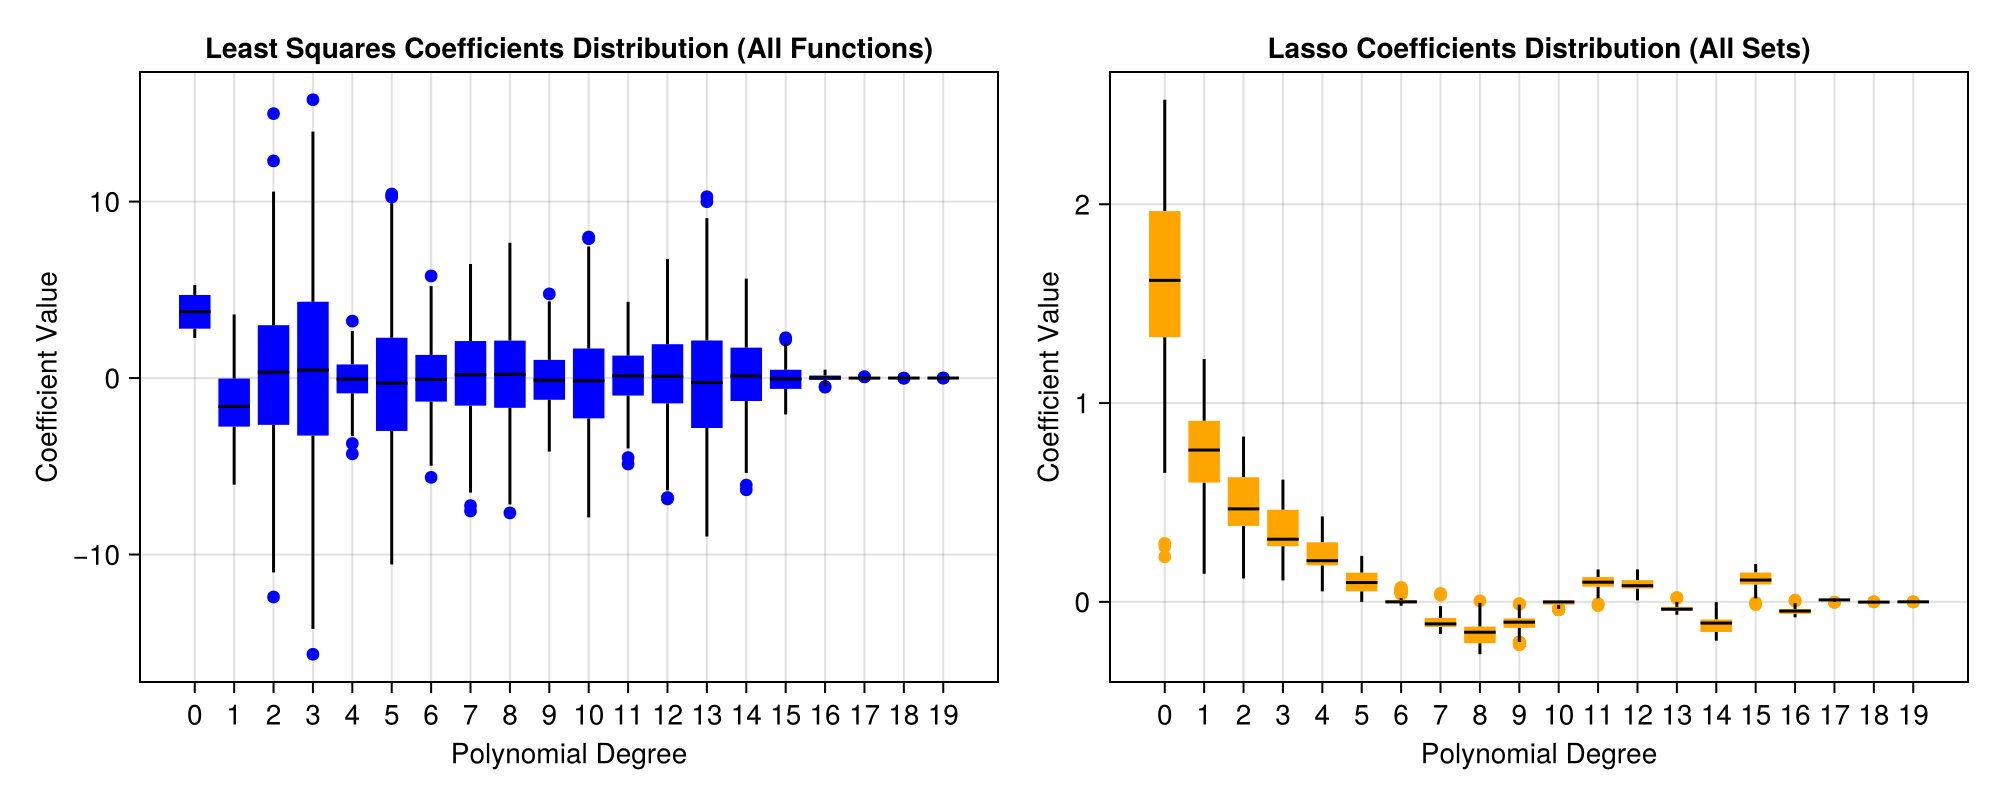

CairoMakie.Screen{IMAGE}


In [11]:
# plots
fig = Figure(size=(1000, 400))

# Least Squares coefficients distribution plot
ax1 = Axis(fig[1, 1],
    title = "Least Squares Coefficients Distribution (All Functions)",
    xlabel = "Polynomial Degree",
    ylabel = "Coefficient Value",
    xticks = 0:19
)
categories_ls = repeat(0:19, inner = size(B_ls_flat, 1))
values_ls = vec(B_ls_flat)
boxplot!(ax1, categories_ls, values_ls, color = :blue)

# Lasso coefficients distribution plot
ax2 = Axis(fig[1, 2],
    title = "Lasso Coefficients Distribution (All Sets)",
    xlabel = "Polynomial Degree",
    ylabel = "Coefficient Value",
    xticks = 0:19
)
categories_lasso = repeat(0:19, inner = size(B_lasso_flat, 1))
values_lasso = vec(B_lasso_flat)
boxplot!(ax2, categories_lasso, values_lasso, color = :orange)
display(fig)

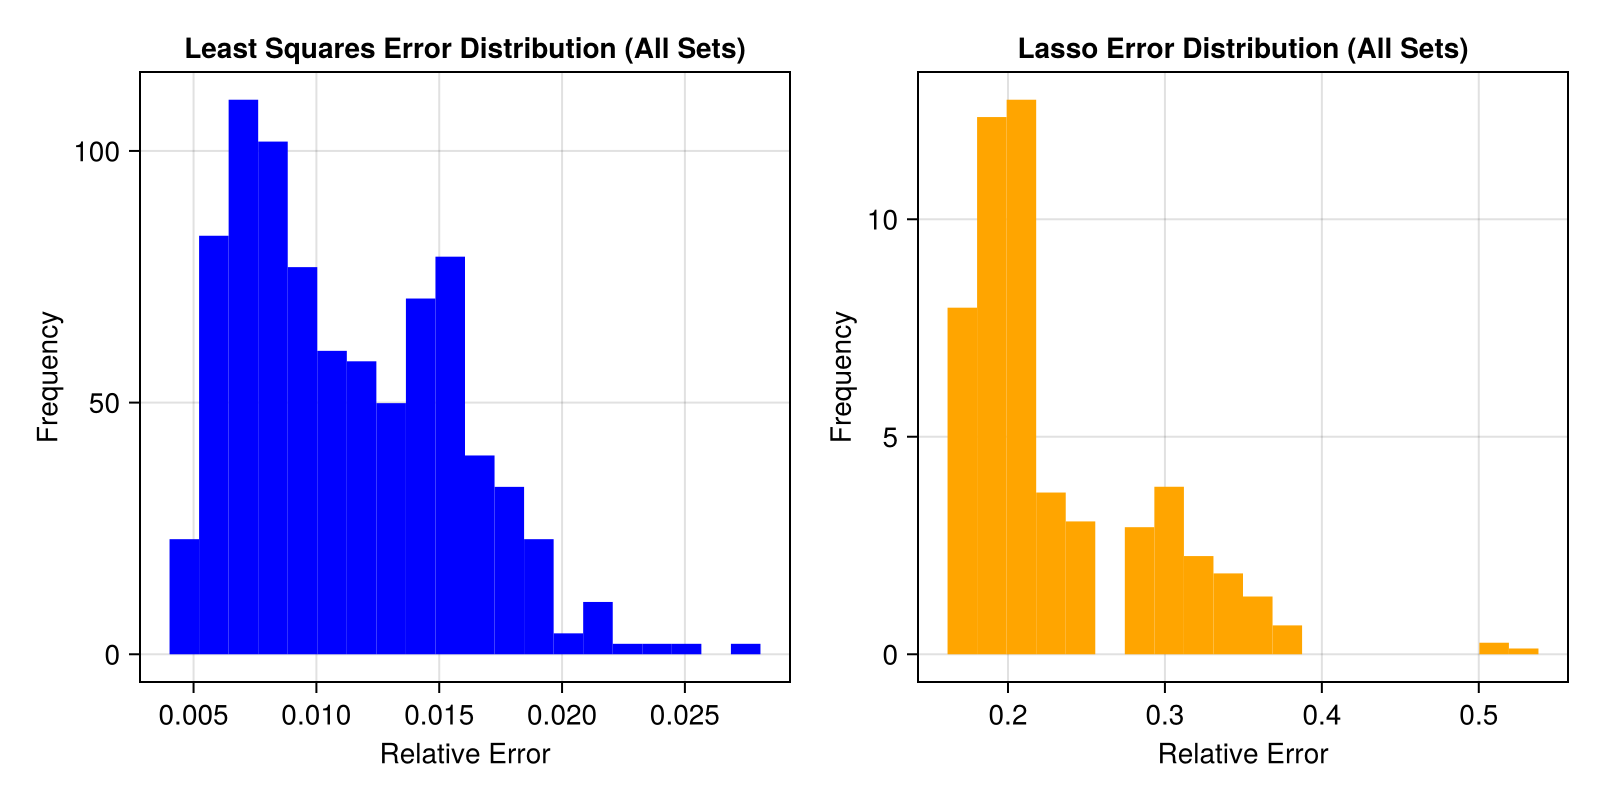

CairoMakie.Screen{IMAGE}


In [14]:
fig_error = Figure(size=(800, 400))
ax3 = Axis(fig_error[1, 1],
    title = "Least Squares Error Distribution (All Sets)",
    xlabel = "Relative Error",
    ylabel = "Frequency"
)
Makie.hist!(ax3, E_ls_flat, bins = 20, color = :blue, normalization = :pdf)
ax4 = Axis(fig_error[1, 2],
    title = "Lasso Error Distribution (All Sets)",
    xlabel = "Relative Error",
    ylabel = "Frequency"
)
Makie.hist!(ax4, E_lasso_flat, bins = 20, color = :orange, normalization = :pdf)
display(fig_error)